# records

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from numba import njit
from collections import namedtuple

In [3]:
# Disable caching for performance testing
# NOTE: Expect waterfall of executions, since some attributes depend on other attributes 
# that have to be calculated again and again
vbt.defaults.caching = False

In [4]:
example_dt = np.dtype([
    ('col', np.int64),
    ('idx', np.int64),
    ('some_field1', np.float64),
    ('some_field2', np.float64)
], align=True)

In [5]:
records_arr = np.asarray([
    (0, 0, 10, 21),
    (0, 1, 11, 20),
    (0, 2, 12, 19),
    (1, 0, 13, 18),
    (1, 1, 14, 17),
    (1, 2, 13, 18),
    (2, 0, 12, 19),
    (2, 1, 11, 20),
    (2, 2, 10, 21)
], dtype=example_dt)
print(records_arr)
print(records_arr.shape)

columns = pd.MultiIndex.from_arrays([[0, 1, 1, 1], ['a', 'b', 'c', 'd']], names=['lvl1', 'lvl2'])
wrapper = vbt.base.array_wrapper.ArrayWrapper(index=['x', 'y', 'z'], columns=columns, ndim=2, freq='1 days')
records = vbt.records.Records(wrapper, records_arr)

records_grouped = vbt.records.Records(wrapper.copy(group_by=0), records_arr)

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
(9,)


In [6]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.random.uniform(size=1000000),
    np.random.uniform(size=1000000)))), dtype=example_dt)
print(big_records_arr.shape)

big_columns = pd.MultiIndex.from_arrays([np.repeat(np.array([0, 1]), 500), np.arange(1000)], names=['lvl1', 'lvl2'])
big_wrapper = vbt.base.array_wrapper.ArrayWrapper(index=np.arange(1000), columns=big_columns, ndim=2, freq='1 days')
big_records = vbt.records.Records(big_wrapper, big_records_arr)

big_records_grouped = vbt.records.Records(big_wrapper.copy(group_by=0), big_records_arr)

(1000000,)


In [7]:
group_by = pd.Series([0, 0, 1, 1], name='group')
big_group_by = pd.Series(np.repeat(np.array([0, 1]), 500))

## MappedArray

In [8]:
mapped_array = records.map_field('some_field1')
big_mapped_array = big_records.map_field('some_field1')

mapped_array_grouped = records_grouped.map_field('some_field1')
big_mapped_array_grouped = big_records_grouped.map_field('some_field1')

In [9]:
print(mapped_array.mapped_arr)
print(mapped_array.col_arr)

[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[0 0 0 1 1 1 2 2 2]


In [10]:
print(mapped_array[(0, 'a')].mapped_arr)
print(mapped_array[(0, 'a')].col_arr)
print(mapped_array[(0, 'a')].wrapper.columns)

print(mapped_array[(1, 'b')].mapped_arr)
print(mapped_array[(1, 'b')].col_arr)
print(mapped_array[(1, 'b')].wrapper.columns)

print(mapped_array[[(0, 'a'), (0, 'a')]].mapped_arr)
print(mapped_array[[(0, 'a'), (0, 'a')]].col_arr)
print(mapped_array[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(mapped_array[[(0, 'a'), (1, 'b')]].mapped_arr)
print(mapped_array[[(0, 'a'), (1, 'b')]].col_arr)
print(mapped_array[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_mapped_array.iloc[0]
%timeit big_mapped_array.iloc[:]

[10. 11. 12.]
[0 0 0]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[13. 14. 13.]
[0 0 0]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 10. 11. 12.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[10. 11. 12. 13. 14. 13.]
[0 0 0 1 1 1]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
2.62 ms ± 67.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
22 ms ± 7.31 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [11]:
print(mapped_array_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(mapped_array_grouped[0].wrapper.ndim)
print(mapped_array_grouped[0].wrapper.grouped_ndim)
print(mapped_array_grouped[0].wrapper.grouper.group_by)

print(mapped_array_grouped[1].wrapper.columns)
print(mapped_array_grouped[1].wrapper.ndim)
print(mapped_array_grouped[1].wrapper.grouped_ndim)
print(mapped_array_grouped[1].wrapper.grouper.group_by)

print(mapped_array_grouped[[0]].wrapper.columns)
print(mapped_array_grouped[[0]].wrapper.ndim)
print(mapped_array_grouped[[0]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0]].wrapper.grouper.group_by)

print(mapped_array_grouped[[0, 1]].wrapper.columns)
print(mapped_array_grouped[[0, 1]].wrapper.ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouped_ndim)
print(mapped_array_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_mapped_array_grouped.iloc[0]
%timeit big_mapped_array_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
12.8 ms ± 901 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
19.8 ms ± 2.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
print(mapped_array.idx_arr)

%timeit big_mapped_array.idx_arr

[0 1 2 0 1 2 0 1 2]
158 ns ± 11.5 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [13]:
print(mapped_array.col_index)

%timeit big_mapped_array.col_index

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
2.81 ms ± 546 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [14]:
mask = mapped_array.mapped_arr >= mapped_array.mapped_arr.mean()
print(mapped_array.filter_by_mask(mask).mapped_arr)

big_mask = big_mapped_array.mapped_arr >= big_mapped_array.mapped_arr.mean()
%timeit big_mapped_array.filter_by_mask(big_mask)

[12. 13. 14. 13. 12.]
23.8 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [15]:
print(mapped_array.to_matrix())
print(mapped_array.to_matrix(default_val=0.))

%timeit big_mapped_array.to_matrix()

lvl1     0     1          
lvl2     a     b     c   d
x     10.0  13.0  12.0 NaN
y     11.0  14.0  11.0 NaN
z     12.0  13.0  10.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
x     10.0  13.0  12.0  0.0
y     11.0  14.0  11.0  0.0
z     12.0  13.0  10.0  0.0
6.4 ms ± 33.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
@njit
def mean_reduce_nb(col, a):
    return np.mean(a)

print(mapped_array[(0, 'a')].reduce(mean_reduce_nb))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb))
print(mapped_array.reduce(mean_reduce_nb, default_val=0.))
print(mapped_array.reduce(mean_reduce_nb, default_val=0., cast=np.int_))
print(mapped_array.reduce(mean_reduce_nb, time_units=True))

%timeit big_mapped_array.reduce(mean_reduce_nb)

11.0
lvl1  lvl2
0     a       11.000000
1     b       13.333333
dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d        0.000000
dtype: float64
lvl1  lvl2
0     a       11
1     b       13
      c       11
      d        0
dtype: int64
lvl1  lvl2
0     a      11 days 00:00:00
1     b      13 days 08:00:00
      c      11 days 00:00:00
      d                   NaT
dtype: timedelta64[ns]
7.18 ms ± 78.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
print(mapped_array_grouped[0].reduce(mean_reduce_nb))
print(mapped_array_grouped[[0]].reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb))
print(mapped_array_grouped.reduce(mean_reduce_nb, group_by=False))

%timeit big_mapped_array_grouped.reduce(mean_reduce_nb)

11.0
lvl1
0    11.0
dtype: float64
lvl1
0    11.000000
1    12.166667
dtype: float64
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
7.49 ms ± 97.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
@njit
def argmin_reduce_nb(col, a):
    return np.argmin(a)

print(mapped_array.reduce(argmin_reduce_nb, to_idx=True))
%timeit big_mapped_array.reduce(argmin_reduce_nb, to_idx=True)

print(mapped_array.reduce(argmin_reduce_nb, to_idx=True, idx_labeled=False))
%timeit big_mapped_array.reduce(argmin_reduce_nb, to_idx=True, idx_labeled=False)

print(mapped_array_grouped.reduce(argmin_reduce_nb, to_idx=True))
%timeit big_mapped_array_grouped.reduce(argmin_reduce_nb, to_idx=True)

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
dtype: object
7.38 ms ± 57.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       0
1     b       0
      c       2
      d      -1
dtype: int64
7.56 ms ± 357 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    x
1    z
dtype: object
7.59 ms ± 72.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
@njit
def min_max_reduce_nb(col, a):
    return np.array([np.min(a), np.max(a)])

print(mapped_array[(0, 'a')].reduce(min_max_reduce_nb, to_array=True, n_rows=2))
print(mapped_array[[(0, 'a'), (1, 'b')]].reduce(min_max_reduce_nb, to_array=True, n_rows=2))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True, n_rows=2))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True, n_rows=2, index=['min', 'max']))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True, n_rows=2, index=['min', 'max'], default_val=0.))
print(mapped_array.reduce(min_max_reduce_nb, to_array=True, n_rows=2, time_units=True))

%timeit big_mapped_array.reduce(min_max_reduce_nb, to_array=True, n_rows=2)

0    10.0
1    12.0
Name: (0, a), dtype: float64
lvl1     0     1
lvl2     a     b
0     10.0  13.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
lvl1     0     1          
lvl2     a     b     c   d
min   10.0  13.0  10.0 NaN
max   12.0  14.0  12.0 NaN
lvl1     0     1           
lvl2     a     b     c    d
min   10.0  13.0  10.0  0.0
max   12.0  14.0  12.0  0.0
lvl1       0       1            
lvl2       a       b       c   d
0    10 days 13 days 10 days NaT
1    12 days 14 days 12 days NaT
8.58 ms ± 60.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [20]:
print(mapped_array_grouped[0].reduce(min_max_reduce_nb, to_array=True, n_rows=2))
print(mapped_array_grouped[[0]].reduce(min_max_reduce_nb, to_array=True, n_rows=2))
print(mapped_array_grouped.reduce(min_max_reduce_nb, to_array=True, n_rows=2))
print(mapped_array_grouped.reduce(min_max_reduce_nb, to_array=True, n_rows=2, group_by=False))

%timeit big_mapped_array_grouped.reduce(min_max_reduce_nb, to_array=True, n_rows=2)

0    10.0
1    12.0
dtype: float64
lvl1     0
0     10.0
1     12.0
lvl1     0     1
0     10.0  10.0
1     12.0  14.0
lvl1     0     1          
lvl2     a     b     c   d
0     10.0  13.0  10.0 NaN
1     12.0  14.0  12.0 NaN
9.67 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
@njit
def idxmin_idxmax_reduce_nb(col, a):
    return np.array([np.argmin(a), np.argmax(a)])

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, n_rows=2, to_idx=True))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, n_rows=2, to_idx=True)

print(mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, n_rows=2, to_idx=True, idx_labeled=False))
%timeit big_mapped_array.reduce(idxmin_idxmax_reduce_nb, to_array=True, n_rows=2, to_idx=True, idx_labeled=False)

print(mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, to_array=True, n_rows=2, to_idx=True))
%timeit big_mapped_array_grouped.reduce(idxmin_idxmax_reduce_nb, to_array=True, n_rows=2, to_idx=True)

lvl1  0  1        
lvl2  a  b  c    d
0     x  x  z  NaN
1     z  y  x  NaN
9.35 ms ± 213 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1      
lvl2  a  b  c  d
0     0  0  2 -1
1     2  1  0 -1
9.2 ms ± 80.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  0  1
0     x  z
1     z  y
9.97 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [22]:
print(mapped_array.nst(0))
print(mapped_array.nst(-1))

%timeit big_mapped_array.nst(0)

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       12.0
      d        NaN
dtype: float64
lvl1  lvl2
0     a       12.0
1     b       13.0
      c       10.0
      d        NaN
dtype: float64
5.25 ms ± 22.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
print(mapped_array.to_matrix().vbt.min())
%timeit big_mapped_array.to_matrix().vbt.min()

print(mapped_array.min())
%timeit big_mapped_array.min()

print(mapped_array_grouped.min())
%timeit big_mapped_array_grouped.min()

lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
dtype: float64
12.6 ms ± 156 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       10.0
1     b       13.0
      c       10.0
      d        NaN
dtype: float64
7.42 ms ± 115 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    10.0
1    10.0
dtype: float64
7.6 ms ± 68 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
print(mapped_array.to_matrix().vbt.max())
%timeit big_mapped_array.to_matrix().vbt.max()

print(mapped_array.max())
%timeit big_mapped_array.max()

print(mapped_array_grouped.max())
%timeit big_mapped_array_grouped.max()

lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
dtype: float64
12.6 ms ± 77.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       12.0
1     b       14.0
      c       12.0
      d        NaN
dtype: float64
7.35 ms ± 16 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    12.0
1    14.0
dtype: float64
7.61 ms ± 91.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
print(mapped_array.to_matrix().vbt.mean())
%timeit big_mapped_array.to_matrix().vbt.mean()

print(mapped_array.mean())
%timeit big_mapped_array.mean()

print(mapped_array_grouped.mean())
%timeit big_mapped_array_grouped.mean()

lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
11.5 ms ± 94 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       11.000000
1     b       13.333333
      c       11.000000
      d             NaN
dtype: float64
7.62 ms ± 75.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    11.000000
1    12.166667
dtype: float64
7.91 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
print(mapped_array.to_matrix().vbt.median())
%timeit big_mapped_array.to_matrix().vbt.median()

print(mapped_array.median())
%timeit big_mapped_array.median()

print(mapped_array_grouped.median())
%timeit big_mapped_array_grouped.median()

lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
dtype: float64
19.5 ms ± 1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1  lvl2
0     a       11.0
1     b       13.0
      c       11.0
      d        NaN
dtype: float64
19.8 ms ± 61 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    11.0
1    12.5
dtype: float64
21.9 ms ± 418 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [27]:
print(mapped_array.to_matrix().vbt.std())
print(mapped_array.to_matrix().vbt.std(ddof=0))
%timeit big_mapped_array.to_matrix().vbt.std()

print(mapped_array.std())
print(mapped_array.std(ddof=0))
%timeit big_mapped_array.std()

print(mapped_array_grouped.std())
%timeit big_mapped_array_grouped.std()

lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
dtype: float64
12.6 ms ± 174 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       1.00000
1     b       0.57735
      c       1.00000
      d           NaN
dtype: float64
lvl1  lvl2
0     a       0.816497
1     b       0.471405
      c       0.816497
      d            NaN
dtype: float64
10.7 ms ± 135 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    1.00000
1    1.47196
dtype: float64
12.6 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [28]:
print(mapped_array.to_matrix().vbt.sum())
%timeit big_mapped_array.to_matrix().vbt.sum()

print(mapped_array.sum())
%timeit big_mapped_array.sum()

print(mapped_array_grouped.sum())
%timeit big_mapped_array_grouped.sum()

lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
11.9 ms ± 89.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
7.38 ms ± 94.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    33.0
1    73.0
dtype: float64
7.63 ms ± 101 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [29]:
print(mapped_array.to_matrix().vbt.count())
%timeit big_mapped_array.to_matrix().vbt.count()

print(mapped_array.count())
%timeit big_mapped_array.count()

print(mapped_array_grouped.count())
%timeit big_mapped_array_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
10.9 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
8.09 ms ± 72.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    3
1    6
dtype: int64
8.2 ms ± 76.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [30]:
print(mapped_array.to_matrix().vbt.describe())
print(mapped_array.to_matrix().vbt.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.to_matrix().vbt.describe()

print(mapped_array.describe())
print(mapped_array.describe(percentiles=[0.3, 0.7]))
%timeit big_mapped_array.describe()

print(mapped_array_grouped.describe())
%timeit big_mapped_array_grouped.describe()

lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0  13.000000  11.0  NaN
75%    11.5  13.500000  11.5  NaN
max    12.0  14.000000  12.0  NaN
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
30%    10.6  13.000000  10.6  NaN
50%    11.0  13.000000  11.0  NaN
70%    11.4  13.400000  11.4  NaN
max    12.0  14.000000  12.0  NaN
47 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
lvl1      0          1           
lvl2      a          b     c    d
count   3.0   3.000000   3.0  0.0
mean   11.0  13.333333  11.0  NaN
std     1.0   0.577350   1.0  NaN
min    10.0  13.000000  10.0  NaN
25%    10.5  13.000000  10.5  NaN
50%    11.0  

In [31]:
print(mapped_array.to_matrix().vbt.idxmin())
%timeit big_mapped_array.to_matrix().vbt.idxmin()

print(mapped_array.idxmin())
%timeit big_mapped_array.idxmin()

print(mapped_array_grouped.idxmin())
%timeit big_mapped_array_grouped.idxmin()

lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
dtype: object
16.1 ms ± 624 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a         x
1     b         x
      c         z
      d       NaN
dtype: object
10.2 ms ± 44.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    x
1    z
dtype: object
11 ms ± 69.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
print(mapped_array.to_matrix().vbt.idxmax())
%timeit big_mapped_array.to_matrix().vbt.idxmax()

print(mapped_array.idxmax())
%timeit big_mapped_array.idxmax()

print(mapped_array_grouped.idxmax())
%timeit big_mapped_array_grouped.idxmax()

lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
dtype: object
15.7 ms ± 51.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1  lvl2
0     a         z
1     b         y
      c         x
      d       NaN
dtype: object
10.2 ms ± 196 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
lvl1
0    z
1    y
dtype: object
11 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


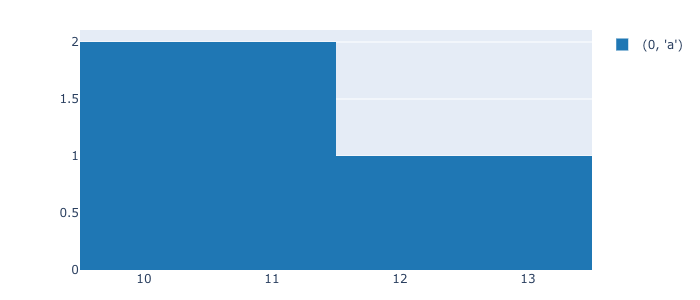

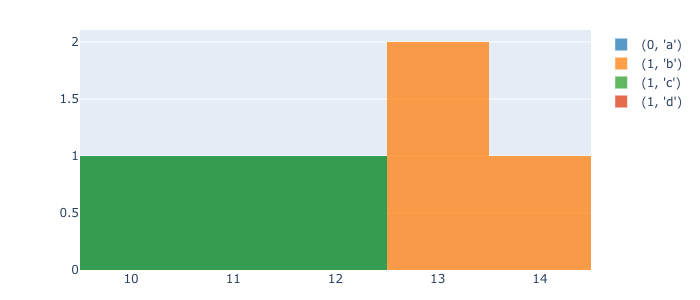

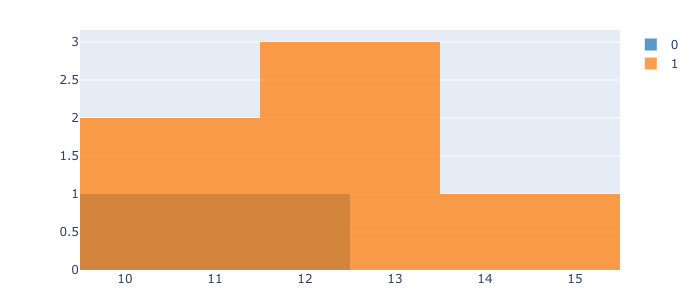

In [33]:
mapped_array[(0, 'a')].hist().show_png()
mapped_array.hist().show_png()
mapped_array_grouped.hist().show_png()

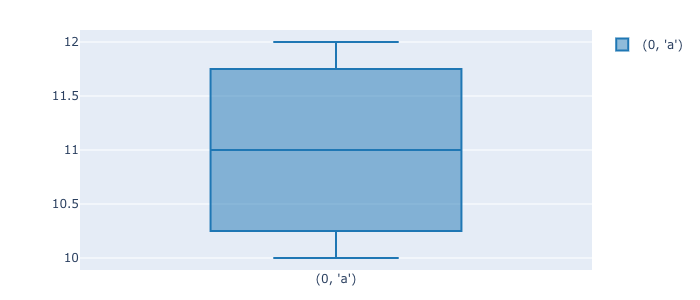

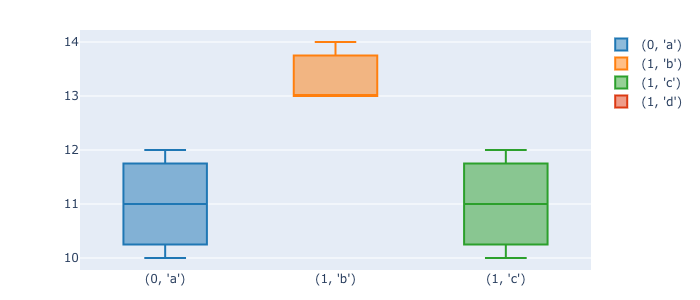

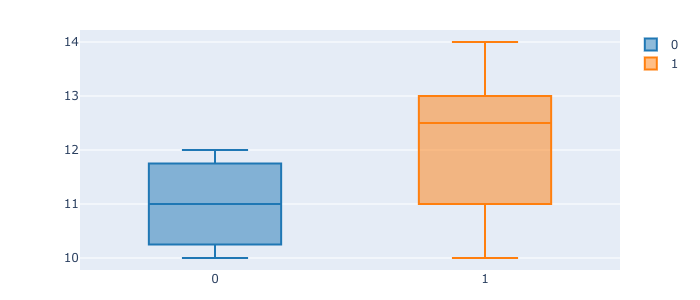

In [34]:
mapped_array[(0, 'a')].box().show_png()
mapped_array.box().show_png()
mapped_array_grouped.box().show_png()

## Records

In [35]:
print(records.records_arr)

print(records.recarray)
%timeit big_records.recarray

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
6.22 µs ± 86.5 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [36]:
print(records.records)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    0    1         11.0         20.0
2    0    2         12.0         19.0
3    1    0         13.0         18.0
4    1    1         14.0         17.0
5    1    2         13.0         18.0
6    2    0         12.0         19.0
7    2    1         11.0         20.0
8    2    2         10.0         21.0


In [37]:
print(records.recarray)

%timeit big_records.recarray

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.) (2, 0, 12., 19.) (2, 1, 11., 20.)
 (2, 2, 10., 21.)]
6.29 µs ± 36 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [38]:
print(records.col_index)

%timeit big_records.col_index

[[ 0  3]
 [ 3  6]
 [ 6  9]
 [-1 -1]]
2.14 ms ± 81.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
print(records.filter_by_mask(mask).records)

%timeit big_records.filter_by_mask(big_mask)

   col  idx  some_field1  some_field2
0    0    2         12.0         19.0
1    1    0         13.0         18.0
2    1    1         14.0         17.0
3    1    2         13.0         18.0
4    2    0         12.0         19.0
13.1 ms ± 905 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [40]:
@njit
def map_nb(record):
    return record.some_field1 + record.some_field2 * 2

print(records.map(map_nb).sum())
print(records_grouped.map(map_nb).sum())
print(records_grouped.map(map_nb, group_by=False).sum())

%timeit vbt.records.MappedArray(\
    big_wrapper,\
    big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2,\
    big_records_arr['col'],\
)
%timeit big_records.map(map_nb)  # faster

lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
dtype: float64
lvl1
0    153.0
1    299.0
dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
dtype: float64
8.33 ms ± 83.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.33 ms ± 64.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
print(records.map_field('col').mapped_arr)
print(records.map_field('idx').mapped_arr)
print(records.map_field('some_field1').mapped_arr)
print(records.map_field('some_field2').mapped_arr)

print(records.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1').sum())
print(records_grouped.map_field('some_field1', group_by=False).sum())

%timeit big_records.map_field('some_field1')

[0 0 0 1 1 1 2 2 2]
[0 1 2 0 1 2 0 1 2]
[10. 11. 12. 13. 14. 13. 12. 11. 10.]
[21. 20. 19. 18. 17. 18. 19. 20. 21.]
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
lvl1
0    33.0
1    73.0
dtype: float64
lvl1  lvl2
0     a       33.0
1     b       40.0
      c       33.0
      d        0.0
dtype: float64
15.1 µs ± 348 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [42]:
print(records.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).mapped_arr)
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2).sum())
print(records_grouped.map_array(records_arr['some_field1'] + records_arr['some_field2'] * 2, group_by=False).sum())

%timeit big_records.map_array(big_records_arr['some_field1'] + big_records_arr['some_field2'] * 2)

[52. 51. 50. 49. 48. 49. 50. 51. 52.]
lvl1
0    153.0
1    299.0
dtype: float64
lvl1  lvl2
0     a       153.0
1     b       146.0
      c       153.0
      d         0.0
dtype: float64
8.32 ms ± 72.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [43]:
print(records.count())
print(records_grouped.count())
print(records_grouped.count(group_by=False))

%timeit big_records.count()
%timeit big_records_grouped.count()

lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
lvl1
0    3
1    6
dtype: int64
lvl1  lvl2
0     a       3
1     b       3
      c       3
      d       0
dtype: int64
5.99 ms ± 57.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.11 ms ± 88.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [44]:
print(records[(0, 'a')].records_arr)
print(records[(0, 'a')].wrapper.columns)

print(records[(1, 'b')].records_arr)
print(records[(1, 'b')].wrapper.columns)

print(records[[(0, 'a'), (0, 'a')]].records_arr)
print(records[[(0, 'a'), (0, 'a')]].wrapper.columns)

print(records[[(0, 'a'), (1, 'b')]].records_arr)
print(records[[(0, 'a'), (1, 'b')]].wrapper.columns)

%timeit big_records.iloc[0]
%timeit big_records.iloc[:]

[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.)]
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 0, 13., 18.) (0, 1, 14., 17.) (0, 2, 13., 18.)]
MultiIndex([(1, 'b')],
           names=['lvl1', 'lvl2'])
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 10., 21.)
 (1, 1, 11., 20.) (1, 2, 12., 19.)]
MultiIndex([(0, 'a'),
            (0, 'a')],
           names=['lvl1', 'lvl2'])
[(0, 0, 10., 21.) (0, 1, 11., 20.) (0, 2, 12., 19.) (1, 0, 13., 18.)
 (1, 1, 14., 17.) (1, 2, 13., 18.)]
MultiIndex([(0, 'a'),
            (1, 'b')],
           names=['lvl1', 'lvl2'])
2.65 ms ± 81.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
print(records_grouped[0].wrapper.columns)  # indexing on groups, not columns!
print(records_grouped[0].wrapper.ndim)
print(records_grouped[0].wrapper.grouped_ndim)
print(records_grouped[0].wrapper.grouper.group_by)

print(records_grouped[1].wrapper.columns)
print(records_grouped[1].wrapper.ndim)
print(records_grouped[1].wrapper.grouped_ndim)
print(records_grouped[1].wrapper.grouper.group_by)

print(records_grouped[[0]].wrapper.columns)
print(records_grouped[[0]].wrapper.ndim)
print(records_grouped[[0]].wrapper.grouped_ndim)
print(records_grouped[[0]].wrapper.grouper.group_by)

print(records_grouped[[0, 1]].wrapper.columns)
print(records_grouped[[0, 1]].wrapper.ndim)
print(records_grouped[[0, 1]].wrapper.grouped_ndim)
print(records_grouped[[0, 1]].wrapper.grouper.group_by)

%timeit big_records_grouped.iloc[0]
%timeit big_records_grouped.iloc[:]

MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
1
1
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
1
Int64Index([1, 1, 1], dtype='int64', name='lvl1')
MultiIndex([(0, 'a')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0], dtype='int64', name='lvl1')
MultiIndex([(0, 'a'),
            (1, 'b'),
            (1, 'c'),
            (1, 'd')],
           names=['lvl1', 'lvl2'])
2
2
Int64Index([0, 1, 1, 1], dtype='int64', name='lvl1')
11.7 ms ± 128 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
14.1 ms ± 3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [46]:
filter_mask = np.array([True, False, False, False, False, False, False, False, True])

print(records.filter_by_mask(filter_mask).count())
print(records_grouped.filter_by_mask(filter_mask).count())
print(records_grouped.filter_by_mask(filter_mask, group_by=False).count())

lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
dtype: int64
lvl1
0    1
1    1
dtype: int64
lvl1  lvl2
0     a       1
1     b       0
      c       1
      d       0
dtype: int64


In [47]:
filtered_records = records.filter_by_mask(filter_mask)
print(filtered_records.records)
print(filtered_records.col_index)

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
1    2    2         10.0         21.0
[[ 0  1]
 [-1 -1]
 [ 1  2]
 [-1 -1]]


In [48]:
print(filtered_records[(0, 'a')].records)
print(filtered_records[(0, 'a')].col_index)
print(filtered_records[(0, 'a')].map_field('some_field1').mapped_arr)
print(filtered_records[(0, 'a')].map_field('some_field1').min())
print(filtered_records[(0, 'a')].count())

   col  idx  some_field1  some_field2
0    0    0         10.0         21.0
[[0 1]]
[10.]
10.0
1


In [49]:
print(filtered_records[(1, 'b')].records)
print(filtered_records[(1, 'b')].col_index)
print(filtered_records[(1, 'b')].map_field('some_field1').mapped_arr)
print(filtered_records[(1, 'b')].map_field('some_field1').min())
print(filtered_records[(1, 'b')].count())

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[[-1 -1]]
[]
nan
0


In [50]:
print(filtered_records[(1, 'c')].records)
print(filtered_records[(1, 'c')].col_index)
print(filtered_records[(1, 'c')].map_field('some_field1').mapped_arr)
print(filtered_records[(1, 'c')].map_field('some_field1').min())
print(filtered_records[(1, 'c')].count())

   col  idx  some_field1  some_field2
0    0    2         10.0         21.0
[[0 1]]
[10.]
10.0
1


In [51]:
print(filtered_records[(1, 'd')].records)
print(filtered_records[(1, 'd')].col_index)
print(filtered_records[(1, 'd')].map_field('some_field1').mapped_arr)
print(filtered_records[(1, 'd')].map_field('some_field1').min())
print(filtered_records[(1, 'd')].count())

Empty DataFrame
Columns: [col, idx, some_field1, some_field2]
Index: []
[[-1 -1]]
[]
nan
0


## Drawdowns

In [52]:
ts = pd.DataFrame({
    'a': [2, 1, 3, 1, 4, 1], 
    'b': [1, 2, 1, 3, 1, 4],
    'c': [1, 2, 3, 2, 1, 2],
    'd': [1, 2, 3, 4, 5, 6]
}).astype(np.float32)

big_ts = pd.DataFrame(np.random.randint(1, 10, size=(1000, 1000)).astype(float))

In [53]:
from vectorbt.records import Drawdowns

drawdowns = Drawdowns.from_ts(ts, freq='1 days')
print(drawdowns.records_arr.shape)

(6,)


In [54]:
big_drawdowns = Drawdowns.from_ts(big_ts, freq='1 days')
print(big_drawdowns.records_arr.shape)

(99933,)


In [55]:
%timeit Drawdowns.from_ts(big_ts, freq='1 days')

7.8 ms ± 41.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [56]:
print(drawdowns.records)
print(drawdowns.ts)

print(drawdowns['a'].records)
print(drawdowns['a'].ts)

%timeit big_drawdowns.iloc[0]
%timeit big_drawdowns.iloc[:]

   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    0          4           5        5       0
3    1          1           2        3       1
4    1          3           4        5       1
5    2          2           4        5       0
     a    b    c    d
0  2.0  1.0  1.0  1.0
1  1.0  2.0  2.0  2.0
2  3.0  1.0  3.0  3.0
3  1.0  3.0  2.0  4.0
4  4.0  1.0  1.0  5.0
5  1.0  4.0  2.0  6.0
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    0          4           5        5       0
0    2.0
1    1.0
2    3.0
3    1.0
4    4.0
5    1.0
Name: a, dtype: float32
678 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
9.83 ms ± 1.29 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


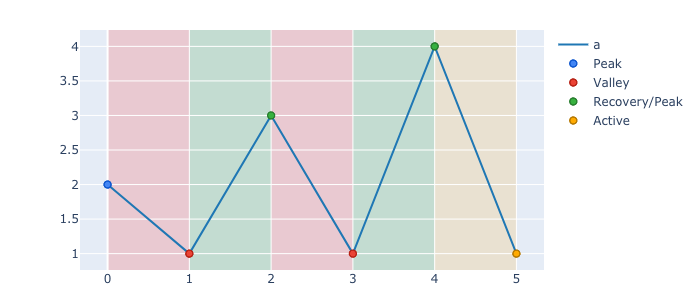

In [57]:
drawdowns['a'].plot().show_png()

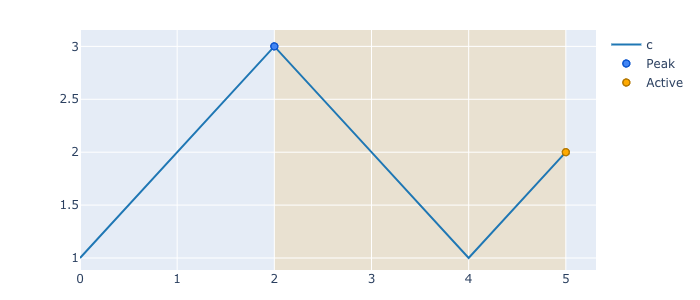

In [58]:
drawdowns.plot(column='c').show_png()

In [59]:
print(drawdowns['a'].count())

print(drawdowns.count())
print(drawdowns.count(group_by=group_by))

3
a    3
b    2
c    1
d    0
dtype: int64
group
0    5
1    1
dtype: int64


In [60]:
print(drawdowns['a'].start_value.to_matrix())
print(drawdowns.start_value.to_matrix())

%timeit big_drawdowns.start_value

0    NaN
1    NaN
2    2.0
3    NaN
4    3.0
5    4.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  2.0  NaN  NaN NaN
3  NaN  2.0  NaN NaN
4  3.0  NaN  NaN NaN
5  4.0  3.0  3.0 NaN
1.72 ms ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [61]:
print(drawdowns['a'].valley_value.to_matrix())
print(drawdowns.valley_value.to_matrix())

%timeit big_drawdowns.valley_value

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  1.0  1.0  1.0 NaN
1.75 ms ± 29.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [62]:
print(drawdowns['a'].end_value.to_matrix())
print(drawdowns.end_value.to_matrix())

%timeit big_drawdowns.end_value

0    NaN
1    NaN
2    3.0
3    NaN
4    4.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  3.0  NaN  NaN NaN
3  NaN  3.0  NaN NaN
4  4.0  NaN  NaN NaN
5  1.0  4.0  2.0 NaN
1.74 ms ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [63]:
print(drawdowns['a'].drawdown.to_matrix())
print(drawdowns.drawdown.to_matrix())

%timeit big_drawdowns.drawdown

0         NaN
1         NaN
2   -0.500000
3         NaN
4   -0.666667
5   -0.750000
Name: a, dtype: float64
          a         b         c   d
0       NaN       NaN       NaN NaN
1       NaN       NaN       NaN NaN
2 -0.500000       NaN       NaN NaN
3       NaN -0.500000       NaN NaN
4 -0.666667       NaN       NaN NaN
5 -0.750000 -0.666667 -0.666667 NaN
3.52 ms ± 47.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [64]:
print(drawdowns['a'].avg_drawdown())
print(drawdowns.avg_drawdown())
%timeit big_drawdowns.avg_drawdown()

print(drawdowns.avg_drawdown(group_by=group_by))
%timeit big_drawdowns.avg_drawdown(group_by=big_group_by)

-0.6388888955116272
a   -0.638889
b   -0.583333
c   -0.666667
d    0.000000
dtype: float64
4.45 ms ± 27 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
0   -0.616667
1   -0.666667
dtype: float64
5.03 ms ± 44.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [65]:
print(drawdowns['a'].max_drawdown())
print(drawdowns.max_drawdown())
%timeit big_drawdowns.max_drawdown()

print(drawdowns.max_drawdown(group_by=group_by))
%timeit big_drawdowns.max_drawdown(group_by=big_group_by)

-0.75
a   -0.750000
b   -0.666667
c   -0.666667
d    0.000000
dtype: float64
4.64 ms ± 180 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
0   -0.750000
1   -0.666667
dtype: float64
5.03 ms ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [66]:
print(drawdowns['a'].duration.to_matrix())
print(drawdowns.duration.to_matrix())

%timeit big_drawdowns.duration

0    NaN
1    NaN
2    2.0
3    NaN
4    2.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  2.0  NaN  NaN NaN
3  NaN  2.0  NaN NaN
4  2.0  NaN  NaN NaN
5  1.0  2.0  3.0 NaN
675 µs ± 9.41 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [67]:
print(drawdowns['a'].avg_duration())
print(drawdowns.avg_duration())
%timeit big_drawdowns.avg_duration()

print(drawdowns.avg_duration(group_by=group_by))
%timeit big_drawdowns.avg_duration(group_by=big_group_by)

1 days 16:00:00
a   1 days 16:00:00
b   2 days 00:00:00
c   3 days 00:00:00
d               NaT
dtype: timedelta64[ns]
1.72 ms ± 66 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
0   1 days 19:12:00
1   3 days 00:00:00
dtype: timedelta64[ns]
2.29 ms ± 46.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [68]:
print(drawdowns['a'].max_duration())
print(drawdowns.max_duration())
%timeit big_drawdowns.max_duration()

print(drawdowns.max_duration(group_by=group_by))
%timeit big_drawdowns.max_duration(group_by=big_group_by)

2 days 00:00:00
a   2 days
b   2 days
c   3 days
d      NaT
dtype: timedelta64[ns]
1.81 ms ± 16.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
group
0   2 days
1   3 days
dtype: timedelta64[ns]
2.3 ms ± 53.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [69]:
print(drawdowns.duration.sum(group_by=group_by))

group
0    9.0
1    3.0
dtype: float64


In [70]:
print(drawdowns['a'].coverage())
print(drawdowns.coverage())
%timeit big_drawdowns.coverage()

print(drawdowns.coverage(group_by=group_by))
%timeit big_drawdowns.coverage(group_by=big_group_by)

0.8333333333333334
a    0.833333
b    0.666667
c    0.500000
d    0.000000
dtype: float64
1.78 ms ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
0    0.75
1    0.25
dtype: float64
2.75 ms ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
print(drawdowns['a'].ptv_duration.to_matrix())
print(drawdowns.ptv_duration.to_matrix())

%timeit big_drawdowns.ptv_duration

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    1.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  1.0  1.0  2.0 NaN
670 µs ± 7.96 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [72]:
print(drawdowns['a'].status.to_matrix())
print(drawdowns.status.to_matrix())

%timeit big_drawdowns.status

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    0.0
Name: a, dtype: float64
     a    b    c   d
0  NaN  NaN  NaN NaN
1  NaN  NaN  NaN NaN
2  1.0  NaN  NaN NaN
3  NaN  1.0  NaN NaN
4  1.0  NaN  NaN NaN
5  0.0  1.0  0.0 NaN
16.3 µs ± 99.4 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [73]:
print(drawdowns['a'].recovered_rate())
print(drawdowns.recovered_rate())
%timeit big_drawdowns.recovered_rate()

print(drawdowns.recovered_rate(group_by=group_by))
%timeit big_drawdowns.recovered_rate(group_by=big_group_by)

0.6666666666666666
a    0.666667
b    1.000000
c    0.000000
d         NaN
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/records/drawdowns.py:456: RuntimeWarning:

invalid value encountered in true_divide



4.85 ms ± 132 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
0    0.8
1    0.0
dtype: float64
6.41 ms ± 709 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [74]:
print(drawdowns.active)
print(drawdowns['a'].active.records)
print(drawdowns.active['a'].records)
print(drawdowns.active.records)

   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
   col  start_idx  valley_idx  end_idx  status
0    0          4           5        5       0
1    2          2           4        5       0


In [75]:
print(drawdowns.recovered)
print(drawdowns['a'].recovered.records)
print(drawdowns.recovered['a'].records)
print(drawdowns.recovered.records)

   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
   col  start_idx  valley_idx  end_idx  status
0    0          0           1        2       1
1    0          2           3        4       1
2    1          1           2        3       1
3    1          3           4        5       1


In [76]:
%timeit big_drawdowns.active

317 µs ± 12.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [77]:
%timeit big_drawdowns.recovered

2.14 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [78]:
print(drawdowns['a'].active.current_drawdown())
print(drawdowns.active.current_drawdown())

%timeit big_drawdowns.active.current_drawdown()

-0.75
a   -0.750000
b         NaN
c   -0.333333
d         NaN
dtype: float64
1.4 ms ± 27.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [79]:
print(drawdowns['a'].active.current_duration())
print(drawdowns.active.current_duration())

%timeit big_drawdowns.active.current_duration()

1 days 00:00:00
a   1 days
b      NaT
c   3 days
d      NaT
dtype: timedelta64[ns]
757 µs ± 17.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [80]:
print(drawdowns['a'].active.current_return())
print(drawdowns.active.current_return())

%timeit big_drawdowns.active.current_return()

0.0
a    0.0
b    NaN
c    1.0
d    NaN
dtype: float64
894 µs ± 280 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [81]:
print(drawdowns['a'].recovered.recovery_return.to_matrix())
print(drawdowns.recovered.recovery_return.to_matrix())

%timeit big_drawdowns.recovered.recovery_return

0    NaN
1    NaN
2    2.0
3    NaN
4    3.0
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  2.0  NaN NaN NaN
3  NaN  2.0 NaN NaN
4  3.0  NaN NaN NaN
5  NaN  3.0 NaN NaN
6.12 ms ± 151 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [82]:
print(drawdowns['a'].recovered.vtr_duration.to_matrix())
print(drawdowns.recovered.vtr_duration.to_matrix())

%timeit big_drawdowns.recovered.vtr_duration

0    NaN
1    NaN
2    1.0
3    NaN
4    1.0
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  1.0  NaN NaN NaN
3  NaN  1.0 NaN NaN
4  1.0  NaN NaN NaN
5  NaN  1.0 NaN NaN
3.13 ms ± 60.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [83]:
print(drawdowns['a'].recovered.vtr_duration_ratio.to_matrix())
print(drawdowns.recovered.vtr_duration_ratio.to_matrix())

%timeit big_drawdowns.recovered.vtr_duration_ratio

0    NaN
1    NaN
2    0.5
3    NaN
4    0.5
5    NaN
Name: a, dtype: float64
     a    b   c   d
0  NaN  NaN NaN NaN
1  NaN  NaN NaN NaN
2  0.5  NaN NaN NaN
3  NaN  0.5 NaN NaN
4  0.5  NaN NaN NaN
5  NaN  0.5 NaN NaN
3.13 ms ± 14.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Orders

In [84]:
from datetime import datetime
price = pd.DataFrame({
    'a': [1, 2, 3, 4, 5, 6, 7],
    'b': [9, 8, 7, 6, 5, 4, 3],
    'c': [1, 2, 3, 4, 3, 2, 1],
    'd': [4, 3, 2, 1, 2, 3, 4]
}).astype(float)

big_price = pd.DataFrame(np.random.uniform(1, 10, size=(1000, 1000)).astype(float))

In [85]:
from vectorbt.records import Orders, order_dt

records_arr = np.asarray([
    (0, 2, 33.00330033, 3., 0.99009901, 0),
    (0, 3, 33.00330033, 4., 1.32013201, 1),
    (0, 4, 25.8798157, 5., 1.29399079, 0),
    (0, 6, 25.8798157, 7., 1.8115871, 1),
    (1, 2, 14.14427157, 7., 0.99009901, 0),
    (1, 3, 14.14427157, 6., 0.84865629, 1),
    (1, 4, 16.63702438, 5., 0.83185122, 0),
    (1, 5, 16.63702438, 4., 0.66548098, 1),
    (2, 0, 99.00990099, 1., 0.99009901, 0),
    (2, 1, 99.00990099, 2., 1.98019802, 1),
    (2, 6, 194.09861778, 1., 1.94098618, 0),
    (3, 2, 49.5049505, 2., 0.99009901, 0),
    (3, 4, 49.5049505, 2., 0.99009901, 1),
    (3, 6, 24.26232722, 4., 0.97049309, 0)
], dtype=order_dt)
print(records_arr.shape)

wrapper = vbt.base.array_wrapper.ArrayWrapper.from_obj(price, freq='1 days')
orders = Orders(wrapper, records_arr, price)
orders_grouped = Orders(wrapper.copy(group_by=group_by), records_arr, price)

(14,)


In [86]:
big_records_arr = np.asarray(list(zip(*(
    np.repeat(np.arange(1000), 1000),
    np.tile(np.arange(1000), 1000),
    np.full(1000000, 10),
    np.random.uniform(1, 10, size=1000000),
    np.full(1000000, 1),
    np.full(1000000, 1)
))), dtype=order_dt)
big_records_arr['side'][::2] = 0
print(big_records_arr.shape)

big_wrapper = vbt.base.array_wrapper.ArrayWrapper.from_obj(big_price, freq='1 days')
big_orders = Orders(big_wrapper, big_records_arr, big_price)
big_orders_grouped = Orders(big_wrapper.copy(group_by=big_group_by), big_records_arr, big_price)

(1000000,)


In [87]:
print(orders.records)
print(orders.close)

print(orders['a'].records)
print(orders['a'].close)

%timeit big_orders.iloc[0]
%timeit big_orders.iloc[:]

%timeit big_orders_grouped.iloc[0]
%timeit big_orders_grouped.iloc[:]

    col  idx        size  price      fees  side
0     0    2   33.003300    3.0  0.990099     0
1     0    3   33.003300    4.0  1.320132     1
2     0    4   25.879816    5.0  1.293991     0
3     0    6   25.879816    7.0  1.811587     1
4     1    2   14.144272    7.0  0.990099     0
5     1    3   14.144272    6.0  0.848656     1
6     1    4   16.637024    5.0  0.831851     0
7     1    5   16.637024    4.0  0.665481     1
8     2    0   99.009901    1.0  0.990099     0
9     2    1   99.009901    2.0  1.980198     1
10    2    6  194.098618    1.0  1.940986     0
11    3    2   49.504950    2.0  0.990099     0
12    3    4   49.504950    2.0  0.990099     1
13    3    6   24.262327    4.0  0.970493     0
     a    b    c    d
0  1.0  9.0  1.0  4.0
1  2.0  8.0  2.0  3.0
2  3.0  7.0  3.0  2.0
3  4.0  6.0  4.0  1.0
4  5.0  5.0  3.0  2.0
5  6.0  4.0  2.0  3.0
6  7.0  3.0  1.0  4.0
   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    3 

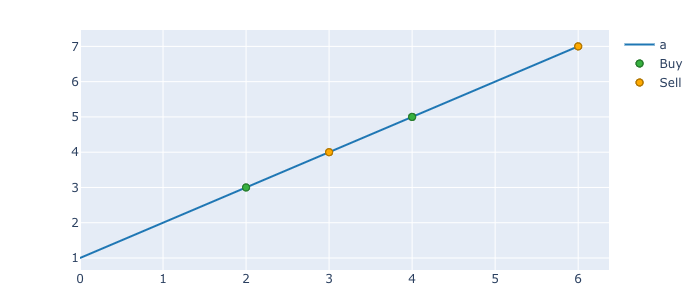

In [88]:
orders['a'].plot().show_png()

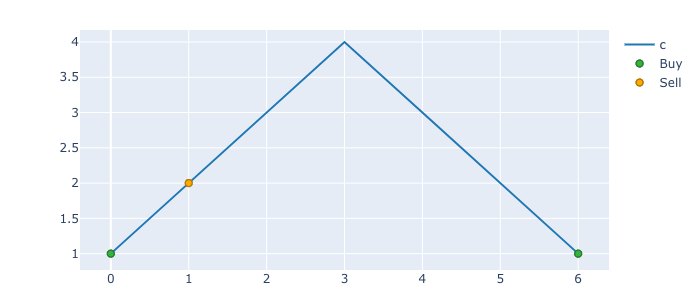

In [89]:
orders.plot(column='c').show_png()

In [90]:
print(orders['a'].size.to_matrix())
print(orders.size.to_matrix())

%timeit big_orders.size

0          NaN
1          NaN
2    33.003300
3    33.003300
4    25.879816
5          NaN
6    25.879816
Name: a, dtype: float64
           a          b           c          d
0        NaN        NaN   99.009901        NaN
1        NaN        NaN   99.009901        NaN
2  33.003300  14.144272         NaN  49.504950
3  33.003300  14.144272         NaN        NaN
4  25.879816  16.637024         NaN  49.504950
5        NaN  16.637024         NaN        NaN
6  25.879816        NaN  194.098618  24.262327
15.6 µs ± 78.9 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [91]:
print(orders['a'].price.to_matrix())
print(orders.price.to_matrix())

%timeit big_orders.price

0    NaN
1    NaN
2    3.0
3    4.0
4    5.0
5    NaN
6    7.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  1.0  NaN
1  NaN  NaN  2.0  NaN
2  3.0  7.0  NaN  2.0
3  4.0  6.0  NaN  NaN
4  5.0  5.0  NaN  2.0
5  NaN  4.0  NaN  NaN
6  7.0  NaN  1.0  4.0
16.4 µs ± 120 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [92]:
print(orders['a'].fees.to_matrix())
print(orders.fees.to_matrix())

%timeit big_orders.fees

0         NaN
1         NaN
2    0.990099
3    1.320132
4    1.293991
5         NaN
6    1.811587
Name: a, dtype: float64
          a         b         c         d
0       NaN       NaN  0.990099       NaN
1       NaN       NaN  1.980198       NaN
2  0.990099  0.990099       NaN  0.990099
3  1.320132  0.848656       NaN       NaN
4  1.293991  0.831851       NaN  0.990099
5       NaN  0.665481       NaN       NaN
6  1.811587       NaN  1.940986  0.970493
16.3 µs ± 99.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [93]:
print(orders['a'].side.to_matrix())
print(orders.side.to_matrix())

%timeit big_orders.side

0    NaN
1    NaN
2    0.0
3    1.0
4    0.0
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  0.0  NaN
1  NaN  NaN  1.0  NaN
2  0.0  0.0  NaN  0.0
3  1.0  1.0  NaN  NaN
4  0.0  0.0  NaN  1.0
5  NaN  1.0  NaN  NaN
6  1.0  NaN  0.0  0.0
16.4 µs ± 174 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [94]:
print(orders.buy)
print(orders['a'].buy.records)
print(orders.buy['a'].records)
print(orders.buy.records)

   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    4  25.879816    5.0  1.293991     0
   col  idx       size  price      fees  side
0    0    2  33.003300    3.0  0.990099     0
1    0    4  25.879816    5.0  1.293991     0
   col  idx        size  price      fees  side
0    0    2   33.003300    3.0  0.990099     0
1    0    4   25.879816    5.0  1.293991     0
2    1    2   14.144272    7.0  0.990099     0
3    1    4   16.637024    5.0  0.831851     0
4    2    0   99.009901    1.0  0.990099     0
5    2    6  194.098618    1.0  1.940986     0
6    3    2   49.504950    2.0  0.990099     0
7    3    6   24.262327    4.0  0.970493     0


In [95]:
print(orders.sell)
print(orders['a'].sell.records)
print(orders.sell['a'].records)
print(orders.sell.records)

   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
   col  idx       size  price      fees  side
0    0    3  33.003300    4.0  1.320132     1
1    0    6  25.879816    7.0  1.811587     1
2    1    3  14.144272    6.0  0.848656     1
3    1    5  16.637024    4.0  0.665481     1
4    2    1  99.009901    2.0  1.980198     1
5    3    4  49.504950    2.0  0.990099     1


In [96]:
%timeit big_orders.buy

17.5 ms ± 3.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [97]:
%timeit big_orders.sell

17.3 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [98]:
print(orders['a'].buy.size.to_matrix())
print(orders.buy.size.to_matrix())

%timeit big_orders.buy.size

0          NaN
1          NaN
2    33.003300
3          NaN
4    25.879816
5          NaN
6          NaN
Name: a, dtype: float64
           a          b           c          d
0        NaN        NaN   99.009901        NaN
1        NaN        NaN         NaN        NaN
2  33.003300  14.144272         NaN  49.504950
3        NaN        NaN         NaN        NaN
4  25.879816  16.637024         NaN        NaN
5        NaN        NaN         NaN        NaN
6        NaN        NaN  194.098618  24.262327
20.2 ms ± 70.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [99]:
print(orders['a'].sell.size.to_matrix())
print(orders.sell.size.to_matrix())

%timeit big_orders.sell.size

0          NaN
1          NaN
2          NaN
3    33.003300
4          NaN
5          NaN
6    25.879816
Name: a, dtype: float64
           a          b          c         d
0        NaN        NaN        NaN       NaN
1        NaN        NaN  99.009901       NaN
2        NaN        NaN        NaN       NaN
3  33.003300  14.144272        NaN       NaN
4        NaN        NaN        NaN  49.50495
5        NaN  16.637024        NaN       NaN
6  25.879816        NaN        NaN       NaN
19.9 ms ± 154 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Trades

In [100]:
from vectorbt.records import Trades

trades = Trades.from_orders(orders)
trades_grouped = Trades.from_orders(orders_grouped)
print(trades.records_arr.shape)

(8,)


In [101]:
big_trades = Trades.from_orders(big_orders)
big_trades_grouped = Trades.from_orders(big_orders_grouped)
print(big_trades.records_arr.shape)

(500000,)


In [102]:
%timeit Trades.from_orders(big_orders)

The slowest run took 9.16 times longer than the fastest. This could mean that an intermediate result is being cached.
33.5 ms ± 28.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [103]:
print(trades.records)
print(trades.close)

print(trades['a'].records)
print(trades['a'].close)

%timeit big_trades.iloc[0]
%timeit big_trades.iloc[:]

%timeit big_trades_grouped.iloc[0]
%timeit big_trades_grouped.iloc[:]

   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   33.003300          2          3.0    0.990099         3         4.0   
1    0   25.879816          4          5.0    1.293991         6         7.0   
2    1   14.144272          2          7.0    0.990099         3         6.0   
3    1   16.637024          4          5.0    0.831851         5         4.0   
4    2   99.009901          0          1.0    0.990099         1         2.0   
5    2  194.098618          6          1.0    1.940986         6         1.0   
6    3   49.504950          2          2.0    0.990099         4         2.0   
7    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
2   0.848656 -15.983027 -0.159830       1             2  
3   0.665481 -18.134357 -0.215842       1      

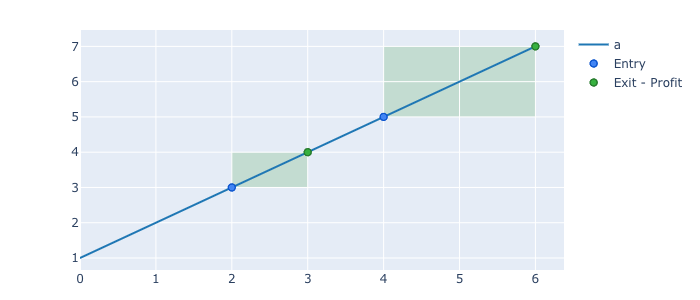

In [104]:
trades['a'].plot().show_png()

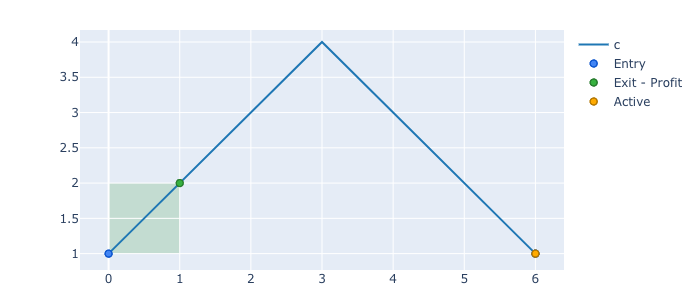

In [105]:
trades.plot(column='c').show_png()

In [106]:
print(trades['a'].count())
print(trades.count())
%timeit big_trades.count()

print(trades_grouped.count())
%timeit big_trades_grouped.count()

2
a    2
b    2
c    2
d    2
dtype: int64
5.28 ms ± 93 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
0    4
1    4
dtype: int64
5.53 ms ± 270 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [107]:
print(trades['a'].duration.to_matrix())
print(trades.duration.to_matrix())

%timeit big_trades.duration

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    2.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  2.0
5  NaN  1.0  NaN  NaN
6  2.0  NaN  0.0  0.0
5.5 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [108]:
print(trades['a'].coverage())
print(trades.coverage())
%timeit big_trades.coverage()

print(trades_grouped.coverage())
%timeit big_trades_grouped.coverage()

0.42857142857142855
a    0.428571
b    0.285714
c    0.142857
d    0.285714
dtype: float64
10.8 ms ± 44 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
group
0    0.357143
1    0.214286
dtype: float64
11.6 ms ± 38.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [109]:
print(trades['a'].pnl.to_matrix())
print(trades.pnl.to_matrix())

%timeit big_trades.pnl

0          NaN
1          NaN
2          NaN
3    30.693069
4          NaN
5          NaN
6    48.654054
Name: a, dtype: float64
           a          b          c         d
0        NaN        NaN        NaN       NaN
1        NaN        NaN  96.039604       NaN
2        NaN        NaN        NaN       NaN
3  30.693069 -15.983027        NaN       NaN
4        NaN        NaN        NaN -1.980198
5        NaN -18.134357        NaN       NaN
6  48.654054        NaN  -1.940986 -0.970493
16.9 µs ± 1.27 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [110]:
print(trades['a'].returns.to_matrix())
print(trades.returns.to_matrix())

%timeit big_trades.returns

0         NaN
1         NaN
2         NaN
3    0.306931
4         NaN
5         NaN
6    0.372277
Name: a, dtype: float64
          a         b         c         d
0       NaN       NaN       NaN       NaN
1       NaN       NaN  0.960396       NaN
2       NaN       NaN       NaN       NaN
3  0.306931 -0.159830       NaN       NaN
4       NaN       NaN       NaN -0.019802
5       NaN -0.215842       NaN       NaN
6  0.372277       NaN -0.009901 -0.009901
16.3 µs ± 1.07 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [111]:
print(trades.winning)
print(trades['a'].winning.records)
print(trades.winning['a'].records)
print(trades.winning.records)

   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816 

In [112]:
print(trades.losing)
print(trades['a'].losing.records)
print(trades.losing['a'].records)
print(trades.losing.records)

Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    1   14.144272          2          7.0    0.990099         3         6.0   
1    1   16.637024          4          5.0    0.831851         5         4.0   
2    2  194.098618          6          1.0    1.940986         6         1.0   
3    3   49.504950          2          2.0    0.990099         4         2.0   
4    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees        pnl    return  status  position_idx  
0   0.848656 -15.983027 -0.159830       1             2  
1   0.665481 -18.134357 -0.215842       1             3  
2   0.000000  -1.940986 -0.009901       0  

In [113]:
%timeit big_trades.winning

16.3 ms ± 2.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [114]:
%timeit big_trades.losing

17.7 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [115]:
print(trades['a'].win_rate())
print(trades.win_rate())
%timeit big_trades.win_rate()

print(trades_grouped.win_rate())
%timeit big_trades_grouped.win_rate()

1.0
a    1.0
b    0.0
c    0.5
d    0.0
dtype: float64
23.3 ms ± 3.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
0    0.50
1    0.25
dtype: float64
25 ms ± 138 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [116]:
print(trades['a'].profit_factor())
print(trades.profit_factor())
%timeit big_trades.profit_factor()

print(trades_grouped.profit_factor())
%timeit big_trades_grouped.profit_factor()

inf
a          inf
b     0.000000
c    49.479798
d     0.000000
dtype: float64


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/records/events.py:353: RuntimeWarning:

divide by zero encountered in true_divide



43.7 ms ± 5.39 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
0     2.325710
1    19.633267
dtype: float64
44.1 ms ± 5.51 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [117]:
print(trades['a'].expectancy())
print(trades.expectancy())
%timeit big_trades.expectancy()

print(trades_grouped.expectancy())
%timeit big_trades_grouped.expectancy()

39.673561410000005
a    39.673561
b   -17.058692
c    47.049309
d    -1.475346
dtype: float64
64 ms ± 862 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
0    11.307435
1    22.786982
dtype: float64
66.3 ms ± 960 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [118]:
print(trades['a'].sqn())
print(trades.sqn())
%timeit big_trades.sqn()

print(trades_grouped.sqn())
%timeit big_trades_grouped.sqn()

4.417749157643597
a     4.417749
b   -15.858742
c     0.960380
d    -2.922330
dtype: float64
21.7 ms ± 287 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
0    0.673531
1    0.933179
dtype: float64
26.8 ms ± 256 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [119]:
print(trades['a'].status.to_matrix())
print(trades.status.to_matrix())

%timeit big_trades.status

0    NaN
1    NaN
2    NaN
3    1.0
4    NaN
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  1.0  NaN
2  NaN  NaN  NaN  NaN
3  1.0  1.0  NaN  NaN
4  NaN  NaN  NaN  1.0
5  NaN  1.0  NaN  NaN
6  1.0  NaN  0.0  0.0
16.6 µs ± 282 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [120]:
print(trades['a'].closed_rate())
print(trades.closed_rate())
%timeit big_trades.closed_rate()

print(trades_grouped.closed_rate())
%timeit big_trades_grouped.closed_rate()

1.0
a    1.0
b    1.0
c    0.5
d    0.5
dtype: float64
32 ms ± 6.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
group
0    1.0
1    0.5
dtype: float64
31.5 ms ± 6.46 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [121]:
print(trades.open)
print(trades['a'].open.records)
print(trades.open['a'].records)
print(trades.open.records)

Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
Empty DataFrame
Columns: [col, size, entry_idx, entry_price, entry_fees, exit_idx, exit_price, exit_fees, pnl, return, status, position_idx]
Index: []
   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    2  194.098618          6          1.0    1.940986         6         1.0   
1    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees       pnl    return  status  position_idx  
0        0.0 -1.940986 -0.009901       0             5  
1        0.0 -0.970493 -0.009901       0             7  


In [122]:
print(trades.closed)
print(trades['a'].closed.records)
print(trades.closed['a'].records)
print(trades.closed.records)

   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816          4          5.0    1.293991         6         7.0   

   exit_fees        pnl    return  status  position_idx  
0   1.320132  30.693069  0.306931       1             0  
1   1.811587  48.654054  0.372277       1             1  
   col       size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0  33.003300          2          3.0    0.990099         3         4.0   
1    0  25.879816 

In [123]:
%timeit big_trades.open # less records

2.94 ms ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [124]:
%timeit big_trades.closed # almost all

45.7 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [125]:
print(trades['a'].position_idx.to_matrix())
print(trades.position_idx.to_matrix())

%timeit big_trades.position_idx

0    NaN
1    NaN
2    NaN
3    0.0
4    NaN
5    NaN
6    1.0
Name: a, dtype: float64
     a    b    c    d
0  NaN  NaN  NaN  NaN
1  NaN  NaN  4.0  NaN
2  NaN  NaN  NaN  NaN
3  0.0  2.0  NaN  NaN
4  NaN  NaN  NaN  6.0
5  NaN  3.0  NaN  NaN
6  1.0  NaN  5.0  7.0
16.2 µs ± 1.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Positions

In [126]:
from vectorbt.records import Positions

positions = Positions.from_orders(orders)
positions_grouped = Positions.from_orders(orders_grouped)
print(positions.records_arr.shape)

(8,)


In [127]:
big_positions = Positions.from_orders(big_orders)
big_positions_grouped = Positions.from_orders(big_orders_grouped)
print(big_positions.records_arr.shape)

(500000,)


In [128]:
%timeit Positions.from_orders(big_orders)

20.9 ms ± 5.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [129]:
print(positions.records)
print(positions.close)

print(positions['a'].records)
print(positions['a'].close)

%timeit big_positions.iloc[0]
%timeit big_positions.iloc[:]

%timeit big_positions_grouped.iloc[0]
%timeit big_positions_grouped.iloc[:]

   col        size  entry_idx  entry_price  entry_fees  exit_idx  exit_price  \
0    0   33.003300          2          3.0    0.990099         3         4.0   
1    0   25.879816          4          5.0    1.293991         6         7.0   
2    1   14.144272          2          7.0    0.990099         3         6.0   
3    1   16.637024          4          5.0    0.831851         5         4.0   
4    2   99.009901          0          1.0    0.990099         1         2.0   
5    2  194.098618          6          1.0    1.940986         6         4.0   
6    3   49.504950          2          2.0    0.990099         4         2.0   
7    3   24.262327          6          4.0    0.970493         6         4.0   

   exit_fees         pnl    return  status  
0   1.320132   30.693069  0.306931       1  
1   1.811587   48.654054  0.372277       1  
2   0.848656  -15.983027 -0.159830       1  
3   0.665481  -18.134357 -0.215842       1  
4   1.980198   96.039604  0.960396       1  
5   0.000

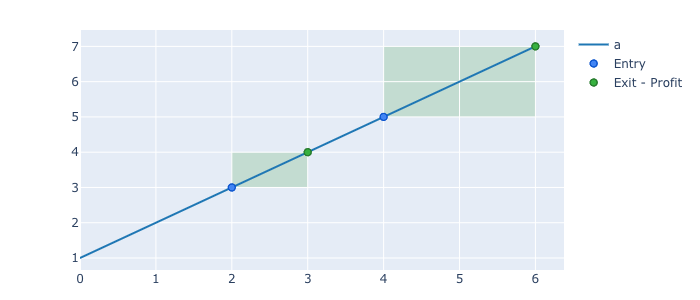

In [130]:
positions['a'].plot().show_png()